# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

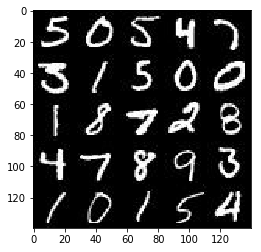

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

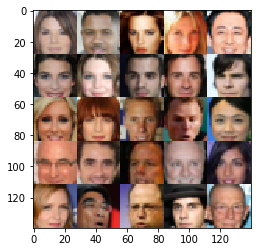

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def c2d_layer(inputs, filters, kernel_size, strides, padding, training, alpha, applyleakyrelu=True):
    
    layer = tf.layers.conv2d(inputs=inputs, filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)
    layer = tf.layers.batch_normalization(layer, training=training)
    if(applyleakyrelu):
        layer = tf.maximum(alpha * layer, layer)
    
    return layer

In [7]:
def discriminator(images, reuse=False, n_units=128, alpha=0.01, training=True):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):

        #def c2d_layer(inputs, filters, kernel_size, strides, padding, training, alpha, applyleakyrelu=True):
        # Input layer is 28 x 28 x 3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14 x 14 x 64
        
        x2 = c2d_layer(relu1, 128, 5, 2, 'same', training, alpha)
        # 7 x 7 x 128
        
        x3 = c2d_layer(x2, 256, 5, 2, 'same', training, alpha)
        # 4 x 4 x 256
        
        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def c2dt_layer(inputs, filters, kernel_size, strides, padding, training, alpha, applyleakyrelu=True):
    
    layer = tf.layers.conv2d_transpose(inputs=inputs, filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)
    layer = tf.layers.batch_normalization(layer, training=training)
    if(applyleakyrelu):
        layer = tf.maximum(alpha * layer, layer)
    
    return layer

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        
        # first fully conencted layer
        x0 = tf.layers.dense(z, 2 * 2 * 1024)
        
        # review comment: I suggest using layers with filters 1024, 512, 256, 128 as the layers 
        # for training your network. There is no need to use two layers each with 256 and 128 as
        # the number of filters.
        
        # reshape
        x0 = tf.reshape(x0, (-1, 2, 2, 1024))
        x0 = tf.layers.batch_normalization(x0, training=is_train)
        x0 = tf.maximum(alpha * x0, x0)
        # now 2 x 2 x 1024
        
        #def c2dt_layer(inputs, filters, kernel_size, strides, padding, training, applyleakyrelu=True):
        x1 = c2dt_layer(x0, 512, 4, 2, 'same', is_train, alpha, True)
        # now 4 x 4 x 512
        
        x2 = c2dt_layer(x1, 256, 4, 1, 'valid', is_train, alpha, True)
        # now 7 x 7 x 256
        
        x3 = c2dt_layer(x2, 128, 4, 2, 'same', is_train, alpha, True)
        # now 14 x 14 x 128

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')

        # now 28 x 28 x 3
        out = tf.tanh(logits)

        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
   
    #d_loss_real = tf.reduce_mean(
#        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - smooth)))

    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        # https://github.com/soumith/ganhacks#14-notsure-train-discriminator-more-sometimes says train
        # discriminator more... not implemented yet...
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt    
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

In [13]:
import numpy as np

def save_generator_output(sess, n_images, input_z, out_channel_dim, image_mode, savepath):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.savefig(savepath, bbox_inches='tight')

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, num_images_show = 25, print_every = 10, show_every = 100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    import time, datetime

    sample_z = np.random.uniform(-1, 1, size=z_dim)
    
    samples, losses = [], []
    steps = 0
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        start = time.time()
        print("Start: {}, batch size {}, LR {}, Beta {}".format(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(start)), batch_size, learning_rate, beta1))
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2

                # Sample random noise for G
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                # reviewer feedback: "Try running generator optimization one more time. It also helps in preventing discriminator loss from going to zero."
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Step: {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    

                if steps % show_every == 0:
                    #def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
                    show_generator_output(sess, num_images_show, input_z, data_shape[3], data_image_mode)
        show_generator_output(sess, num_images_show, input_z, data_shape[3], data_image_mode) 
        done = time.time()
        elapsed = done - start
        print("Final discriminator loss: {:.4f}, final generator loss: {:.4f}".format(losses[-1][0], losses[-1][1]))
        save_generator_output(sess, num_images_show, input_z, data_shape[3], data_image_mode, os.path.join('./out/batch-{}-lr{}-beta{}-d{:.4f}-g{:.4f}.jpg'.format(batch_size, learning_rate, beta1,losses[-1][0], losses[-1][1])))
        print("Done at {} - elapsed time: {}".format(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(done)), str(datetime.timedelta(seconds=elapsed))))

        
    return losses, samples                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Start: 2018-03-18 09:46:49, batch size 50, LR 0.001, Beta 0.05
Epoch 1/2... Step: 10... Discriminator Loss: 5.1233... Generator Loss: 10.4417
Epoch 1/2... Step: 20... Discriminator Loss: 3.6805... Generator Loss: 13.1632
Epoch 1/2... Step: 30... Discriminator Loss: 3.9813... Generator Loss: 0.0231
Epoch 1/2... Step: 40... Discriminator Loss: 2.3035... Generator Loss: 0.1264
Epoch 1/2... Step: 50... Discriminator Loss: 2.2105... Generator Loss: 0.2120
Epoch 1/2... Step: 60... Discriminator Loss: 2.6505... Generator Loss: 0.0822
Epoch 1/2... Step: 70... Discriminator Loss: 2.1386... Generator Loss: 0.1558
Epoch 1/2... Step: 80... Discriminator Loss: 2.0482... Generator Loss: 0.1522
Epoch 1/2... Step: 90... Discriminator Loss: 2.1788... Generator Loss: 0.1374
Epoch 1/2... Step: 100... Discriminator Loss: 2.2410... Generator Loss: 0.1483


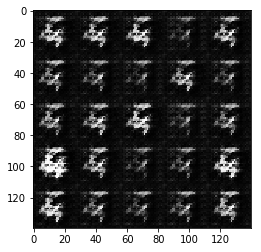

Epoch 1/2... Step: 110... Discriminator Loss: 2.1028... Generator Loss: 0.1680
Epoch 1/2... Step: 120... Discriminator Loss: 1.8679... Generator Loss: 0.2731
Epoch 1/2... Step: 130... Discriminator Loss: 1.4544... Generator Loss: 0.3509
Epoch 1/2... Step: 140... Discriminator Loss: 1.5230... Generator Loss: 0.2974
Epoch 1/2... Step: 150... Discriminator Loss: 2.0295... Generator Loss: 0.1646
Epoch 1/2... Step: 160... Discriminator Loss: 1.7318... Generator Loss: 0.2509
Epoch 1/2... Step: 170... Discriminator Loss: 1.8336... Generator Loss: 0.2029
Epoch 1/2... Step: 180... Discriminator Loss: 2.6257... Generator Loss: 0.1400
Epoch 1/2... Step: 190... Discriminator Loss: 1.6776... Generator Loss: 0.2731
Epoch 1/2... Step: 200... Discriminator Loss: 2.3068... Generator Loss: 0.1370


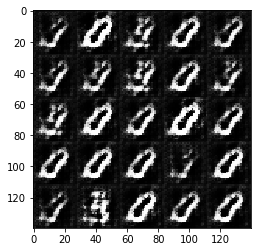

Epoch 1/2... Step: 210... Discriminator Loss: 1.7798... Generator Loss: 0.2660
Epoch 1/2... Step: 220... Discriminator Loss: 2.3802... Generator Loss: 0.1230
Epoch 1/2... Step: 230... Discriminator Loss: 1.8536... Generator Loss: 0.2374
Epoch 1/2... Step: 240... Discriminator Loss: 1.9639... Generator Loss: 0.2160
Epoch 1/2... Step: 250... Discriminator Loss: 1.8198... Generator Loss: 0.2621
Epoch 1/2... Step: 260... Discriminator Loss: 2.2640... Generator Loss: 0.1537
Epoch 1/2... Step: 270... Discriminator Loss: 1.8384... Generator Loss: 0.2361
Epoch 1/2... Step: 280... Discriminator Loss: 1.7244... Generator Loss: 0.2837
Epoch 1/2... Step: 290... Discriminator Loss: 1.9032... Generator Loss: 0.2165
Epoch 1/2... Step: 300... Discriminator Loss: 2.0025... Generator Loss: 0.1800


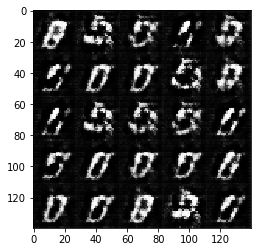

Epoch 1/2... Step: 310... Discriminator Loss: 1.9321... Generator Loss: 0.1936
Epoch 1/2... Step: 320... Discriminator Loss: 1.7331... Generator Loss: 0.2936
Epoch 1/2... Step: 330... Discriminator Loss: 1.6202... Generator Loss: 0.3173
Epoch 1/2... Step: 340... Discriminator Loss: 1.7323... Generator Loss: 0.2633
Epoch 1/2... Step: 350... Discriminator Loss: 1.7871... Generator Loss: 0.2493
Epoch 1/2... Step: 360... Discriminator Loss: 1.8321... Generator Loss: 0.2408
Epoch 1/2... Step: 370... Discriminator Loss: 2.0245... Generator Loss: 0.1885
Epoch 1/2... Step: 380... Discriminator Loss: 1.5452... Generator Loss: 0.3234
Epoch 1/2... Step: 390... Discriminator Loss: 1.7855... Generator Loss: 0.2507
Epoch 1/2... Step: 400... Discriminator Loss: 1.9182... Generator Loss: 0.1961


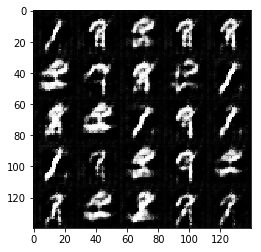

Epoch 1/2... Step: 410... Discriminator Loss: 1.8575... Generator Loss: 0.2221
Epoch 1/2... Step: 420... Discriminator Loss: 1.9813... Generator Loss: 0.1941
Epoch 1/2... Step: 430... Discriminator Loss: 1.8101... Generator Loss: 0.2346
Epoch 1/2... Step: 440... Discriminator Loss: 2.0629... Generator Loss: 0.1672
Epoch 1/2... Step: 450... Discriminator Loss: 1.8731... Generator Loss: 0.2183
Epoch 1/2... Step: 460... Discriminator Loss: 1.7732... Generator Loss: 0.9875
Epoch 1/2... Step: 470... Discriminator Loss: 1.7914... Generator Loss: 1.2656
Epoch 1/2... Step: 480... Discriminator Loss: 1.6639... Generator Loss: 1.0574
Epoch 1/2... Step: 490... Discriminator Loss: 1.4780... Generator Loss: 1.0245
Epoch 1/2... Step: 500... Discriminator Loss: 1.5441... Generator Loss: 1.0975


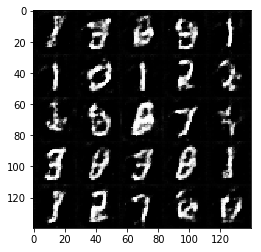

Epoch 1/2... Step: 510... Discriminator Loss: 1.4606... Generator Loss: 0.9234
Epoch 1/2... Step: 520... Discriminator Loss: 1.8602... Generator Loss: 1.4870
Epoch 1/2... Step: 530... Discriminator Loss: 1.7446... Generator Loss: 0.8457
Epoch 1/2... Step: 540... Discriminator Loss: 1.6325... Generator Loss: 0.8010
Epoch 1/2... Step: 550... Discriminator Loss: 1.4839... Generator Loss: 0.7525
Epoch 1/2... Step: 560... Discriminator Loss: 1.7096... Generator Loss: 1.1230
Epoch 1/2... Step: 570... Discriminator Loss: 1.6846... Generator Loss: 1.0437
Epoch 1/2... Step: 580... Discriminator Loss: 1.6097... Generator Loss: 0.9503
Epoch 1/2... Step: 590... Discriminator Loss: 1.5541... Generator Loss: 1.1491
Epoch 1/2... Step: 600... Discriminator Loss: 1.6150... Generator Loss: 0.8107


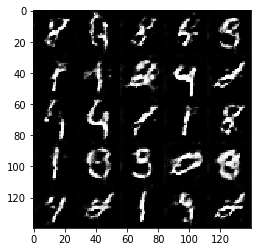

Epoch 1/2... Step: 610... Discriminator Loss: 1.7045... Generator Loss: 1.0205
Epoch 1/2... Step: 620... Discriminator Loss: 1.6811... Generator Loss: 0.8509
Epoch 1/2... Step: 630... Discriminator Loss: 1.5383... Generator Loss: 0.9983
Epoch 1/2... Step: 640... Discriminator Loss: 1.6121... Generator Loss: 0.6804
Epoch 1/2... Step: 650... Discriminator Loss: 1.5073... Generator Loss: 0.9591
Epoch 1/2... Step: 660... Discriminator Loss: 1.4681... Generator Loss: 1.0167
Epoch 1/2... Step: 670... Discriminator Loss: 1.7538... Generator Loss: 0.8808
Epoch 1/2... Step: 680... Discriminator Loss: 1.8566... Generator Loss: 0.9226
Epoch 1/2... Step: 690... Discriminator Loss: 1.6207... Generator Loss: 0.8600
Epoch 1/2... Step: 700... Discriminator Loss: 1.5636... Generator Loss: 0.9925


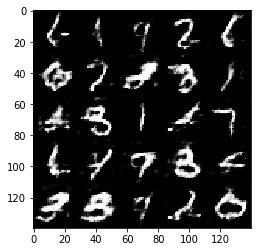

Epoch 1/2... Step: 710... Discriminator Loss: 1.7567... Generator Loss: 0.8137
Epoch 1/2... Step: 720... Discriminator Loss: 1.6309... Generator Loss: 0.7092
Epoch 1/2... Step: 730... Discriminator Loss: 1.5828... Generator Loss: 0.8571
Epoch 1/2... Step: 740... Discriminator Loss: 1.4817... Generator Loss: 0.7662
Epoch 1/2... Step: 750... Discriminator Loss: 1.6199... Generator Loss: 1.0382
Epoch 1/2... Step: 760... Discriminator Loss: 1.6265... Generator Loss: 0.6808
Epoch 1/2... Step: 770... Discriminator Loss: 1.8197... Generator Loss: 1.0712
Epoch 1/2... Step: 780... Discriminator Loss: 1.5588... Generator Loss: 0.7282
Epoch 1/2... Step: 790... Discriminator Loss: 1.6581... Generator Loss: 0.7638
Epoch 1/2... Step: 800... Discriminator Loss: 1.6302... Generator Loss: 0.8061


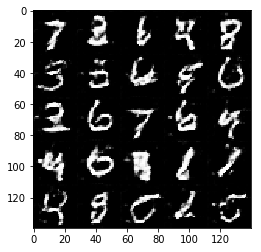

Epoch 1/2... Step: 810... Discriminator Loss: 1.5396... Generator Loss: 1.0791
Epoch 1/2... Step: 820... Discriminator Loss: 1.7160... Generator Loss: 0.7889
Epoch 1/2... Step: 830... Discriminator Loss: 1.5332... Generator Loss: 0.7266
Epoch 1/2... Step: 840... Discriminator Loss: 1.4809... Generator Loss: 0.7050
Epoch 1/2... Step: 850... Discriminator Loss: 1.6289... Generator Loss: 1.0514
Epoch 1/2... Step: 860... Discriminator Loss: 1.5950... Generator Loss: 0.7794
Epoch 1/2... Step: 870... Discriminator Loss: 1.5534... Generator Loss: 1.0858
Epoch 1/2... Step: 880... Discriminator Loss: 1.6563... Generator Loss: 1.0243
Epoch 1/2... Step: 890... Discriminator Loss: 1.4415... Generator Loss: 0.6598
Epoch 1/2... Step: 900... Discriminator Loss: 1.5678... Generator Loss: 0.8376


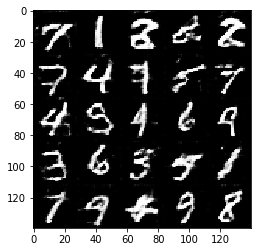

Epoch 1/2... Step: 910... Discriminator Loss: 1.5008... Generator Loss: 0.4033
Epoch 1/2... Step: 920... Discriminator Loss: 1.9214... Generator Loss: 0.2094
Epoch 1/2... Step: 930... Discriminator Loss: 1.9145... Generator Loss: 0.2035
Epoch 1/2... Step: 940... Discriminator Loss: 1.8818... Generator Loss: 0.2322
Epoch 1/2... Step: 950... Discriminator Loss: 1.7794... Generator Loss: 0.2842
Epoch 1/2... Step: 960... Discriminator Loss: 1.9772... Generator Loss: 0.2019
Epoch 1/2... Step: 970... Discriminator Loss: 1.8253... Generator Loss: 0.2410
Epoch 1/2... Step: 980... Discriminator Loss: 1.9836... Generator Loss: 0.1882
Epoch 1/2... Step: 990... Discriminator Loss: 1.7304... Generator Loss: 0.2828
Epoch 1/2... Step: 1000... Discriminator Loss: 1.8668... Generator Loss: 0.2166


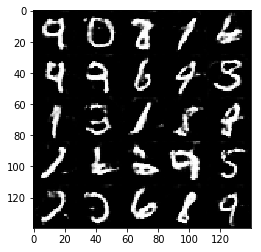

Epoch 1/2... Step: 1010... Discriminator Loss: 1.4909... Generator Loss: 0.5042
Epoch 1/2... Step: 1020... Discriminator Loss: 1.3731... Generator Loss: 0.5982
Epoch 1/2... Step: 1030... Discriminator Loss: 1.5557... Generator Loss: 0.4698
Epoch 1/2... Step: 1040... Discriminator Loss: 2.0988... Generator Loss: 0.1593
Epoch 1/2... Step: 1050... Discriminator Loss: 1.8105... Generator Loss: 0.2377
Epoch 1/2... Step: 1060... Discriminator Loss: 1.8510... Generator Loss: 0.2198
Epoch 1/2... Step: 1070... Discriminator Loss: 1.9932... Generator Loss: 0.1857
Epoch 1/2... Step: 1080... Discriminator Loss: 1.6460... Generator Loss: 0.3249
Epoch 1/2... Step: 1090... Discriminator Loss: 2.0493... Generator Loss: 0.1722
Epoch 1/2... Step: 1100... Discriminator Loss: 1.6210... Generator Loss: 0.3185


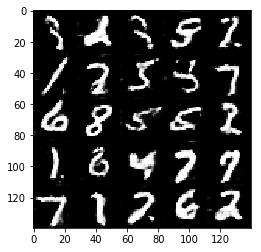

Epoch 1/2... Step: 1110... Discriminator Loss: 1.7291... Generator Loss: 0.2784
Epoch 1/2... Step: 1120... Discriminator Loss: 1.5794... Generator Loss: 0.3543
Epoch 1/2... Step: 1130... Discriminator Loss: 2.0795... Generator Loss: 0.1704
Epoch 1/2... Step: 1140... Discriminator Loss: 1.6770... Generator Loss: 0.3146
Epoch 1/2... Step: 1150... Discriminator Loss: 1.4695... Generator Loss: 0.8592
Epoch 1/2... Step: 1160... Discriminator Loss: 1.4575... Generator Loss: 1.2012
Epoch 1/2... Step: 1170... Discriminator Loss: 1.3869... Generator Loss: 0.6561
Epoch 1/2... Step: 1180... Discriminator Loss: 1.9532... Generator Loss: 0.1979
Epoch 1/2... Step: 1190... Discriminator Loss: 1.9120... Generator Loss: 0.2084
Epoch 1/2... Step: 1200... Discriminator Loss: 1.8069... Generator Loss: 0.2382


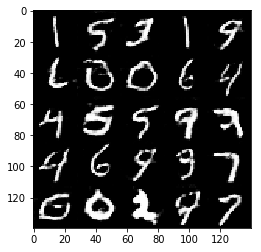

Epoch 2/2... Step: 1210... Discriminator Loss: 1.4413... Generator Loss: 0.4724
Epoch 2/2... Step: 1220... Discriminator Loss: 1.4534... Generator Loss: 0.7692
Epoch 2/2... Step: 1230... Discriminator Loss: 1.3777... Generator Loss: 0.7658
Epoch 2/2... Step: 1240... Discriminator Loss: 1.3725... Generator Loss: 0.9834
Epoch 2/2... Step: 1250... Discriminator Loss: 1.4530... Generator Loss: 0.9620
Epoch 2/2... Step: 1260... Discriminator Loss: 1.5900... Generator Loss: 0.3289
Epoch 2/2... Step: 1270... Discriminator Loss: 1.9013... Generator Loss: 0.2150
Epoch 2/2... Step: 1280... Discriminator Loss: 1.5083... Generator Loss: 0.4116
Epoch 2/2... Step: 1290... Discriminator Loss: 1.7483... Generator Loss: 0.2963
Epoch 2/2... Step: 1300... Discriminator Loss: 1.5849... Generator Loss: 0.3385


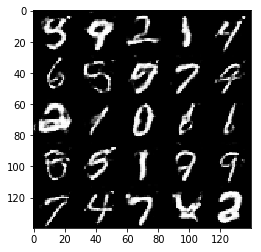

Epoch 2/2... Step: 1310... Discriminator Loss: 1.6904... Generator Loss: 0.3186
Epoch 2/2... Step: 1320... Discriminator Loss: 1.6459... Generator Loss: 0.3064
Epoch 2/2... Step: 1330... Discriminator Loss: 1.6481... Generator Loss: 0.3022
Epoch 2/2... Step: 1340... Discriminator Loss: 1.5003... Generator Loss: 0.4079
Epoch 2/2... Step: 1350... Discriminator Loss: 1.8501... Generator Loss: 0.2335
Epoch 2/2... Step: 1360... Discriminator Loss: 1.8806... Generator Loss: 0.2143
Epoch 2/2... Step: 1370... Discriminator Loss: 1.7741... Generator Loss: 0.2347
Epoch 2/2... Step: 1380... Discriminator Loss: 1.5287... Generator Loss: 0.3974
Epoch 2/2... Step: 1390... Discriminator Loss: 1.2902... Generator Loss: 1.0232
Epoch 2/2... Step: 1400... Discriminator Loss: 1.3440... Generator Loss: 0.8340


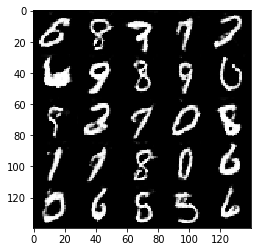

Epoch 2/2... Step: 1410... Discriminator Loss: 1.4482... Generator Loss: 0.8043
Epoch 2/2... Step: 1420... Discriminator Loss: 1.5077... Generator Loss: 0.8115
Epoch 2/2... Step: 1430... Discriminator Loss: 1.5682... Generator Loss: 0.7208
Epoch 2/2... Step: 1440... Discriminator Loss: 1.3851... Generator Loss: 0.8850
Epoch 2/2... Step: 1450... Discriminator Loss: 1.4409... Generator Loss: 0.7926
Epoch 2/2... Step: 1460... Discriminator Loss: 1.3860... Generator Loss: 0.7662
Epoch 2/2... Step: 1470... Discriminator Loss: 1.3352... Generator Loss: 0.8852
Epoch 2/2... Step: 1480... Discriminator Loss: 1.4444... Generator Loss: 1.2061
Epoch 2/2... Step: 1490... Discriminator Loss: 1.3803... Generator Loss: 0.7982
Epoch 2/2... Step: 1500... Discriminator Loss: 1.4388... Generator Loss: 1.0178


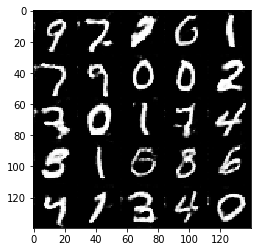

Epoch 2/2... Step: 1510... Discriminator Loss: 1.4516... Generator Loss: 1.0937
Epoch 2/2... Step: 1520... Discriminator Loss: 1.5277... Generator Loss: 0.3707
Epoch 2/2... Step: 1530... Discriminator Loss: 1.6388... Generator Loss: 0.3093
Epoch 2/2... Step: 1540... Discriminator Loss: 1.3826... Generator Loss: 0.4235
Epoch 2/2... Step: 1550... Discriminator Loss: 1.7054... Generator Loss: 0.2731
Epoch 2/2... Step: 1560... Discriminator Loss: 1.5637... Generator Loss: 0.3650
Epoch 2/2... Step: 1570... Discriminator Loss: 1.8568... Generator Loss: 0.2216
Epoch 2/2... Step: 1580... Discriminator Loss: 1.5214... Generator Loss: 0.3838
Epoch 2/2... Step: 1590... Discriminator Loss: 1.8845... Generator Loss: 0.2152
Epoch 2/2... Step: 1600... Discriminator Loss: 1.8784... Generator Loss: 0.2191


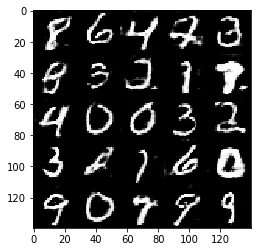

Epoch 2/2... Step: 1610... Discriminator Loss: 1.4415... Generator Loss: 0.9277
Epoch 2/2... Step: 1620... Discriminator Loss: 1.3681... Generator Loss: 0.4887
Epoch 2/2... Step: 1630... Discriminator Loss: 1.5129... Generator Loss: 0.4243
Epoch 2/2... Step: 1640... Discriminator Loss: 1.2342... Generator Loss: 0.9676
Epoch 2/2... Step: 1650... Discriminator Loss: 1.4513... Generator Loss: 0.9638
Epoch 2/2... Step: 1660... Discriminator Loss: 1.3842... Generator Loss: 0.8208
Epoch 2/2... Step: 1670... Discriminator Loss: 1.4364... Generator Loss: 0.4298
Epoch 2/2... Step: 1680... Discriminator Loss: 1.7171... Generator Loss: 0.2655
Epoch 2/2... Step: 1690... Discriminator Loss: 1.3529... Generator Loss: 0.4944
Epoch 2/2... Step: 1700... Discriminator Loss: 1.6206... Generator Loss: 1.1168


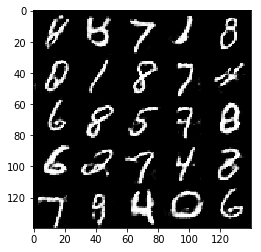

Epoch 2/2... Step: 1710... Discriminator Loss: 1.5038... Generator Loss: 0.4160
Epoch 2/2... Step: 1720... Discriminator Loss: 1.5081... Generator Loss: 0.3547
Epoch 2/2... Step: 1730... Discriminator Loss: 1.7978... Generator Loss: 0.2784
Epoch 2/2... Step: 1740... Discriminator Loss: 1.4581... Generator Loss: 1.0951
Epoch 2/2... Step: 1750... Discriminator Loss: 1.2586... Generator Loss: 0.6540
Epoch 2/2... Step: 1760... Discriminator Loss: 1.4643... Generator Loss: 0.8548
Epoch 2/2... Step: 1770... Discriminator Loss: 1.6387... Generator Loss: 0.4403
Epoch 2/2... Step: 1780... Discriminator Loss: 1.8971... Generator Loss: 0.2123
Epoch 2/2... Step: 1790... Discriminator Loss: 1.8489... Generator Loss: 0.2243
Epoch 2/2... Step: 1800... Discriminator Loss: 1.7225... Generator Loss: 0.2526


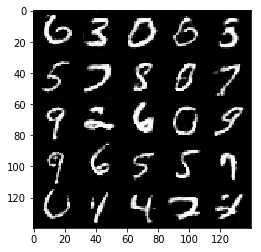

Epoch 2/2... Step: 1810... Discriminator Loss: 1.6688... Generator Loss: 0.3014
Epoch 2/2... Step: 1820... Discriminator Loss: 1.9230... Generator Loss: 0.1904
Epoch 2/2... Step: 1830... Discriminator Loss: 1.5643... Generator Loss: 0.3755
Epoch 2/2... Step: 1840... Discriminator Loss: 1.8764... Generator Loss: 0.2029
Epoch 2/2... Step: 1850... Discriminator Loss: 1.9664... Generator Loss: 0.2010
Epoch 2/2... Step: 1860... Discriminator Loss: 1.8393... Generator Loss: 0.2171
Epoch 2/2... Step: 1870... Discriminator Loss: 1.8257... Generator Loss: 0.2179
Epoch 2/2... Step: 1880... Discriminator Loss: 1.9264... Generator Loss: 0.2065
Epoch 2/2... Step: 1890... Discriminator Loss: 2.0425... Generator Loss: 0.1744
Epoch 2/2... Step: 1900... Discriminator Loss: 2.0080... Generator Loss: 0.1833


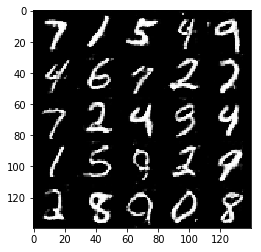

Epoch 2/2... Step: 1910... Discriminator Loss: 1.2606... Generator Loss: 0.5693
Epoch 2/2... Step: 1920... Discriminator Loss: 1.6536... Generator Loss: 0.2966
Epoch 2/2... Step: 1930... Discriminator Loss: 1.7405... Generator Loss: 0.2634
Epoch 2/2... Step: 1940... Discriminator Loss: 1.5196... Generator Loss: 0.3523
Epoch 2/2... Step: 1950... Discriminator Loss: 1.3579... Generator Loss: 0.7707
Epoch 2/2... Step: 1960... Discriminator Loss: 1.6520... Generator Loss: 1.4419
Epoch 2/2... Step: 1970... Discriminator Loss: 1.6854... Generator Loss: 0.2545
Epoch 2/2... Step: 1980... Discriminator Loss: 1.9001... Generator Loss: 0.2154
Epoch 2/2... Step: 1990... Discriminator Loss: 1.4255... Generator Loss: 0.3862
Epoch 2/2... Step: 2000... Discriminator Loss: 1.7073... Generator Loss: 0.2974


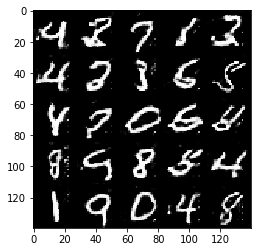

Epoch 2/2... Step: 2010... Discriminator Loss: 1.4734... Generator Loss: 0.4264
Epoch 2/2... Step: 2020... Discriminator Loss: 1.7040... Generator Loss: 0.2896
Epoch 2/2... Step: 2030... Discriminator Loss: 1.7649... Generator Loss: 0.2528
Epoch 2/2... Step: 2040... Discriminator Loss: 1.6698... Generator Loss: 0.3371
Epoch 2/2... Step: 2050... Discriminator Loss: 1.9390... Generator Loss: 0.2132
Epoch 2/2... Step: 2060... Discriminator Loss: 1.5324... Generator Loss: 0.4186
Epoch 2/2... Step: 2070... Discriminator Loss: 1.4214... Generator Loss: 0.4850
Epoch 2/2... Step: 2080... Discriminator Loss: 1.5782... Generator Loss: 0.6649
Epoch 2/2... Step: 2090... Discriminator Loss: 1.3452... Generator Loss: 0.4955
Epoch 2/2... Step: 2100... Discriminator Loss: 1.7441... Generator Loss: 0.2457


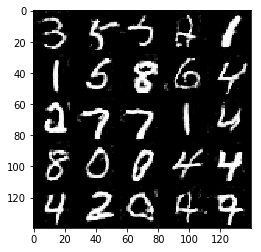

Epoch 2/2... Step: 2110... Discriminator Loss: 1.6748... Generator Loss: 0.2842
Epoch 2/2... Step: 2120... Discriminator Loss: 1.6264... Generator Loss: 0.3322
Epoch 2/2... Step: 2130... Discriminator Loss: 1.7030... Generator Loss: 0.2631
Epoch 2/2... Step: 2140... Discriminator Loss: 2.1027... Generator Loss: 0.1646
Epoch 2/2... Step: 2150... Discriminator Loss: 1.3238... Generator Loss: 0.4135
Epoch 2/2... Step: 2160... Discriminator Loss: 1.7110... Generator Loss: 0.2584
Epoch 2/2... Step: 2170... Discriminator Loss: 1.5800... Generator Loss: 0.4112
Epoch 2/2... Step: 2180... Discriminator Loss: 1.4172... Generator Loss: 0.4837
Epoch 2/2... Step: 2190... Discriminator Loss: 1.3414... Generator Loss: 0.8054
Epoch 2/2... Step: 2200... Discriminator Loss: 1.3234... Generator Loss: 0.8517


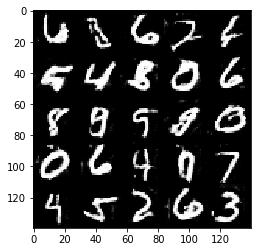

Epoch 2/2... Step: 2210... Discriminator Loss: 1.3615... Generator Loss: 1.0433
Epoch 2/2... Step: 2220... Discriminator Loss: 1.4011... Generator Loss: 0.3906
Epoch 2/2... Step: 2230... Discriminator Loss: 1.7110... Generator Loss: 0.2558
Epoch 2/2... Step: 2240... Discriminator Loss: 1.6242... Generator Loss: 0.3129
Epoch 2/2... Step: 2250... Discriminator Loss: 1.8491... Generator Loss: 0.2228
Epoch 2/2... Step: 2260... Discriminator Loss: 1.5692... Generator Loss: 0.3204
Epoch 2/2... Step: 2270... Discriminator Loss: 1.3015... Generator Loss: 0.6373
Epoch 2/2... Step: 2280... Discriminator Loss: 1.4988... Generator Loss: 0.3629
Epoch 2/2... Step: 2290... Discriminator Loss: 1.8387... Generator Loss: 0.2224
Epoch 2/2... Step: 2300... Discriminator Loss: 1.6443... Generator Loss: 0.2855


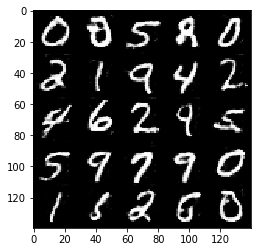

Epoch 2/2... Step: 2310... Discriminator Loss: 1.3650... Generator Loss: 0.4961
Epoch 2/2... Step: 2320... Discriminator Loss: 1.6771... Generator Loss: 0.2762
Epoch 2/2... Step: 2330... Discriminator Loss: 1.5287... Generator Loss: 0.3386
Epoch 2/2... Step: 2340... Discriminator Loss: 1.4809... Generator Loss: 0.3694
Epoch 2/2... Step: 2350... Discriminator Loss: 1.6660... Generator Loss: 0.2845
Epoch 2/2... Step: 2360... Discriminator Loss: 1.5871... Generator Loss: 0.3023
Epoch 2/2... Step: 2370... Discriminator Loss: 1.7881... Generator Loss: 0.2354
Epoch 2/2... Step: 2380... Discriminator Loss: 1.5827... Generator Loss: 0.3140
Epoch 2/2... Step: 2390... Discriminator Loss: 1.4772... Generator Loss: 0.3229
Epoch 2/2... Step: 2400... Discriminator Loss: 1.6647... Generator Loss: 0.3013


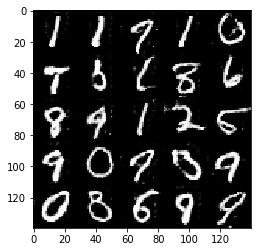

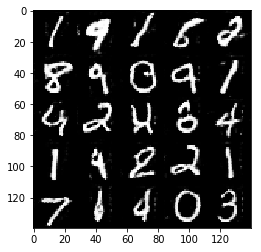

Final discriminator loss: 1.6647, final generator loss: 0.3013
Done at 2018-03-18 09:56:22 - elapsed time: 0:09:33.635125


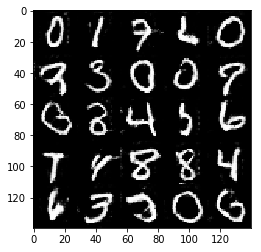

In [19]:
batch_size = 50 #64
z_dim = 150 #150
learning_rate = 0.001 #0.002
beta1 = 0.05 # 0.05


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
"""
this cell is set up to allow me to try multiple values for the hyperparameters
it executed for many, many hours
the final values i've selected are somewhat of a mix from here
"""


batch_size = 32, 64
z_dim = 100
learning_rate =  0.0002, 0.0006, 0.0008, .002, .008
beta1 = .2, 0.5, .8, .02, .05, .08

epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
for bs in batch_size:
    for lr in learning_rate:
        for b in beta1:
            with tf.Graph().as_default():
                #def train(epoch_count, batch_size, z_dim, learning_rate, beta1, 
                            #get_batches, data_shape, data_image_mode, num_images_show = 25, 
                            #print_every = 10, show_every = 100):
  
                train(epochs, bs, z_dim, lr, b, celeba_dataset.get_batches,
                      celeba_dataset.shape, celeba_dataset.image_mode, print_every = 100, show_every = 1000)

Start: 2018-03-18 09:56:26, batch size 64, LR 0.002, Beta 0.5
Epoch 1/1... Step: 10... Discriminator Loss: 10.6506... Generator Loss: 0.0000
Epoch 1/1... Step: 20... Discriminator Loss: 5.8147... Generator Loss: 0.0489
Epoch 1/1... Step: 30... Discriminator Loss: 1.3477... Generator Loss: 1.2773
Epoch 1/1... Step: 40... Discriminator Loss: 2.7743... Generator Loss: 0.1452
Epoch 1/1... Step: 50... Discriminator Loss: 1.3789... Generator Loss: 0.4382
Epoch 1/1... Step: 60... Discriminator Loss: 2.5184... Generator Loss: 0.3625
Epoch 1/1... Step: 70... Discriminator Loss: 2.0273... Generator Loss: 0.3135
Epoch 1/1... Step: 80... Discriminator Loss: 3.1568... Generator Loss: 1.5772
Epoch 1/1... Step: 90... Discriminator Loss: 2.1076... Generator Loss: 0.2746
Epoch 1/1... Step: 100... Discriminator Loss: 2.1221... Generator Loss: 1.4879


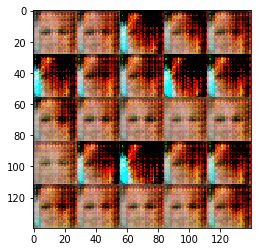

Epoch 1/1... Step: 110... Discriminator Loss: 0.7593... Generator Loss: 2.4449
Epoch 1/1... Step: 120... Discriminator Loss: 0.4829... Generator Loss: 1.7086
Epoch 1/1... Step: 130... Discriminator Loss: 2.7642... Generator Loss: 5.2718
Epoch 1/1... Step: 140... Discriminator Loss: 2.5047... Generator Loss: 0.1176
Epoch 1/1... Step: 150... Discriminator Loss: 2.1673... Generator Loss: 0.5545
Epoch 1/1... Step: 160... Discriminator Loss: 1.1950... Generator Loss: 2.2102
Epoch 1/1... Step: 170... Discriminator Loss: 1.0631... Generator Loss: 1.0347
Epoch 1/1... Step: 180... Discriminator Loss: 1.3777... Generator Loss: 0.6995
Epoch 1/1... Step: 190... Discriminator Loss: 1.4482... Generator Loss: 1.2735
Epoch 1/1... Step: 200... Discriminator Loss: 2.1645... Generator Loss: 1.4901


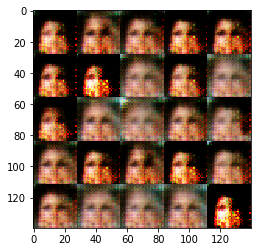

Epoch 1/1... Step: 210... Discriminator Loss: 1.6052... Generator Loss: 0.6257
Epoch 1/1... Step: 220... Discriminator Loss: 0.8678... Generator Loss: 1.0034
Epoch 1/1... Step: 230... Discriminator Loss: 2.0144... Generator Loss: 0.2092
Epoch 1/1... Step: 240... Discriminator Loss: 1.3717... Generator Loss: 1.9139
Epoch 1/1... Step: 250... Discriminator Loss: 1.7511... Generator Loss: 0.3132
Epoch 1/1... Step: 260... Discriminator Loss: 1.7274... Generator Loss: 0.6573
Epoch 1/1... Step: 270... Discriminator Loss: 1.3437... Generator Loss: 0.5917
Epoch 1/1... Step: 280... Discriminator Loss: 1.2519... Generator Loss: 0.7730
Epoch 1/1... Step: 290... Discriminator Loss: 1.4061... Generator Loss: 0.9941
Epoch 1/1... Step: 300... Discriminator Loss: 1.7022... Generator Loss: 0.3771


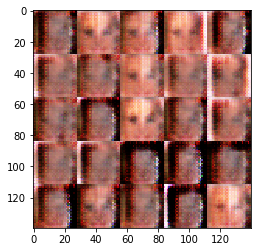

Epoch 1/1... Step: 310... Discriminator Loss: 1.4656... Generator Loss: 0.5946
Epoch 1/1... Step: 320... Discriminator Loss: 1.7662... Generator Loss: 0.4909
Epoch 1/1... Step: 330... Discriminator Loss: 1.9980... Generator Loss: 0.4852
Epoch 1/1... Step: 340... Discriminator Loss: 1.9824... Generator Loss: 0.2179
Epoch 1/1... Step: 350... Discriminator Loss: 1.4095... Generator Loss: 0.5359
Epoch 1/1... Step: 360... Discriminator Loss: 1.3459... Generator Loss: 0.4725
Epoch 1/1... Step: 370... Discriminator Loss: 1.4937... Generator Loss: 0.4976
Epoch 1/1... Step: 380... Discriminator Loss: 1.4808... Generator Loss: 0.4131
Epoch 1/1... Step: 390... Discriminator Loss: 1.5130... Generator Loss: 0.5214
Epoch 1/1... Step: 400... Discriminator Loss: 1.7155... Generator Loss: 0.3737


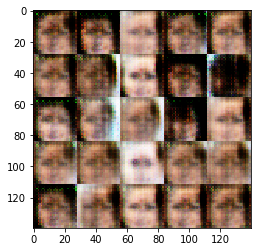

Epoch 1/1... Step: 410... Discriminator Loss: 1.2159... Generator Loss: 0.9558
Epoch 1/1... Step: 420... Discriminator Loss: 1.3204... Generator Loss: 0.8042
Epoch 1/1... Step: 430... Discriminator Loss: 1.4006... Generator Loss: 1.0325
Epoch 1/1... Step: 440... Discriminator Loss: 1.4214... Generator Loss: 0.5099
Epoch 1/1... Step: 450... Discriminator Loss: 1.3505... Generator Loss: 0.5322
Epoch 1/1... Step: 460... Discriminator Loss: 1.3423... Generator Loss: 0.5597
Epoch 1/1... Step: 470... Discriminator Loss: 1.3318... Generator Loss: 1.0724
Epoch 1/1... Step: 480... Discriminator Loss: 1.3594... Generator Loss: 0.9570
Epoch 1/1... Step: 490... Discriminator Loss: 1.2684... Generator Loss: 0.9824
Epoch 1/1... Step: 500... Discriminator Loss: 1.4938... Generator Loss: 0.7821


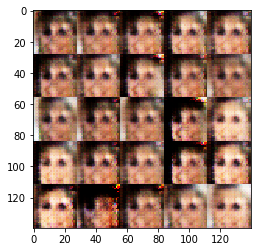

Epoch 1/1... Step: 510... Discriminator Loss: 1.3587... Generator Loss: 0.7400
Epoch 1/1... Step: 520... Discriminator Loss: 1.3555... Generator Loss: 0.8084
Epoch 1/1... Step: 530... Discriminator Loss: 1.2632... Generator Loss: 0.6383
Epoch 1/1... Step: 540... Discriminator Loss: 1.1255... Generator Loss: 0.8705
Epoch 1/1... Step: 550... Discriminator Loss: 1.3524... Generator Loss: 0.4043
Epoch 1/1... Step: 560... Discriminator Loss: 1.4094... Generator Loss: 1.0003
Epoch 1/1... Step: 570... Discriminator Loss: 1.7494... Generator Loss: 0.2936
Epoch 1/1... Step: 580... Discriminator Loss: 1.9063... Generator Loss: 0.1931
Epoch 1/1... Step: 590... Discriminator Loss: 0.9970... Generator Loss: 1.1421
Epoch 1/1... Step: 600... Discriminator Loss: 0.8720... Generator Loss: 2.3369


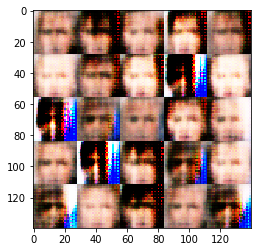

Epoch 1/1... Step: 610... Discriminator Loss: 1.1071... Generator Loss: 0.6741
Epoch 1/1... Step: 620... Discriminator Loss: 0.9534... Generator Loss: 1.0401
Epoch 1/1... Step: 630... Discriminator Loss: 1.0080... Generator Loss: 1.9107
Epoch 1/1... Step: 640... Discriminator Loss: 1.8394... Generator Loss: 0.3883
Epoch 1/1... Step: 650... Discriminator Loss: 1.8073... Generator Loss: 0.4765
Epoch 1/1... Step: 660... Discriminator Loss: 1.4126... Generator Loss: 0.6242
Epoch 1/1... Step: 670... Discriminator Loss: 1.0700... Generator Loss: 0.8022
Epoch 1/1... Step: 680... Discriminator Loss: 1.2314... Generator Loss: 0.6102
Epoch 1/1... Step: 690... Discriminator Loss: 1.4714... Generator Loss: 0.4892
Epoch 1/1... Step: 700... Discriminator Loss: 1.2361... Generator Loss: 0.8013


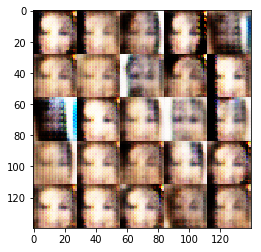

Epoch 1/1... Step: 710... Discriminator Loss: 1.2684... Generator Loss: 1.5780
Epoch 1/1... Step: 720... Discriminator Loss: 1.3807... Generator Loss: 1.4328
Epoch 1/1... Step: 730... Discriminator Loss: 1.2869... Generator Loss: 0.8490
Epoch 1/1... Step: 740... Discriminator Loss: 1.0147... Generator Loss: 1.0027
Epoch 1/1... Step: 750... Discriminator Loss: 1.1215... Generator Loss: 0.8575
Epoch 1/1... Step: 760... Discriminator Loss: 1.6012... Generator Loss: 0.2999
Epoch 1/1... Step: 770... Discriminator Loss: 3.1434... Generator Loss: 1.9257
Epoch 1/1... Step: 780... Discriminator Loss: 1.2531... Generator Loss: 0.5142
Epoch 1/1... Step: 790... Discriminator Loss: 1.8001... Generator Loss: 0.3577
Epoch 1/1... Step: 800... Discriminator Loss: 2.9579... Generator Loss: 1.6936


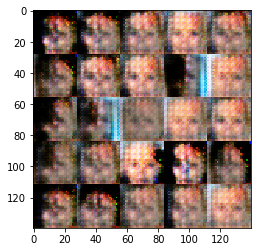

Epoch 1/1... Step: 810... Discriminator Loss: 1.4067... Generator Loss: 0.7422
Epoch 1/1... Step: 820... Discriminator Loss: 1.4530... Generator Loss: 0.8210
Epoch 1/1... Step: 830... Discriminator Loss: 1.4226... Generator Loss: 0.5650
Epoch 1/1... Step: 840... Discriminator Loss: 1.0854... Generator Loss: 1.1139
Epoch 1/1... Step: 850... Discriminator Loss: 0.9940... Generator Loss: 0.8284
Epoch 1/1... Step: 860... Discriminator Loss: 0.8380... Generator Loss: 0.7384
Epoch 1/1... Step: 870... Discriminator Loss: 1.1741... Generator Loss: 0.7049
Epoch 1/1... Step: 880... Discriminator Loss: 1.2295... Generator Loss: 1.2919
Epoch 1/1... Step: 890... Discriminator Loss: 0.6079... Generator Loss: 1.0930
Epoch 1/1... Step: 900... Discriminator Loss: 2.0929... Generator Loss: 0.1987


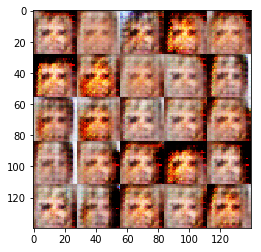

Epoch 1/1... Step: 910... Discriminator Loss: 1.2517... Generator Loss: 1.2645
Epoch 1/1... Step: 920... Discriminator Loss: 1.0772... Generator Loss: 0.7680
Epoch 1/1... Step: 930... Discriminator Loss: 1.2174... Generator Loss: 1.0511
Epoch 1/1... Step: 940... Discriminator Loss: 1.0552... Generator Loss: 0.8291
Epoch 1/1... Step: 950... Discriminator Loss: 1.3263... Generator Loss: 0.7823
Epoch 1/1... Step: 960... Discriminator Loss: 1.1446... Generator Loss: 0.6965
Epoch 1/1... Step: 970... Discriminator Loss: 1.2043... Generator Loss: 0.8449
Epoch 1/1... Step: 980... Discriminator Loss: 0.9981... Generator Loss: 0.8724
Epoch 1/1... Step: 990... Discriminator Loss: 1.6272... Generator Loss: 0.6572
Epoch 1/1... Step: 1000... Discriminator Loss: 1.3883... Generator Loss: 0.4628


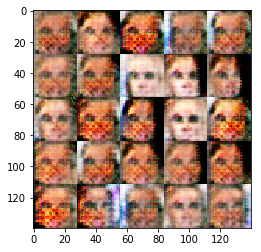

Epoch 1/1... Step: 1010... Discriminator Loss: 1.5252... Generator Loss: 0.3777
Epoch 1/1... Step: 1020... Discriminator Loss: 0.6690... Generator Loss: 1.0530
Epoch 1/1... Step: 1030... Discriminator Loss: 1.6633... Generator Loss: 0.7499
Epoch 1/1... Step: 1040... Discriminator Loss: 1.1127... Generator Loss: 0.7002
Epoch 1/1... Step: 1050... Discriminator Loss: 1.2509... Generator Loss: 0.5557
Epoch 1/1... Step: 1060... Discriminator Loss: 1.3822... Generator Loss: 0.5765
Epoch 1/1... Step: 1070... Discriminator Loss: 0.8967... Generator Loss: 0.7069
Epoch 1/1... Step: 1080... Discriminator Loss: 1.1984... Generator Loss: 0.8746
Epoch 1/1... Step: 1090... Discriminator Loss: 1.1883... Generator Loss: 0.6710
Epoch 1/1... Step: 1100... Discriminator Loss: 0.5145... Generator Loss: 1.2084


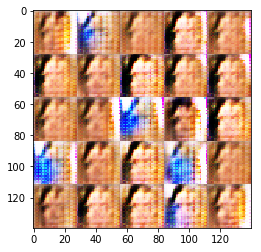

Epoch 1/1... Step: 1110... Discriminator Loss: 2.1175... Generator Loss: 1.9496
Epoch 1/1... Step: 1120... Discriminator Loss: 1.6276... Generator Loss: 0.4744
Epoch 1/1... Step: 1130... Discriminator Loss: 1.1654... Generator Loss: 0.6095
Epoch 1/1... Step: 1140... Discriminator Loss: 0.1153... Generator Loss: 2.4759
Epoch 1/1... Step: 1150... Discriminator Loss: 0.7661... Generator Loss: 0.8369
Epoch 1/1... Step: 1160... Discriminator Loss: 1.3668... Generator Loss: 0.7413
Epoch 1/1... Step: 1170... Discriminator Loss: 1.1070... Generator Loss: 0.5487
Epoch 1/1... Step: 1180... Discriminator Loss: 1.1948... Generator Loss: 0.4782
Epoch 1/1... Step: 1190... Discriminator Loss: 1.2701... Generator Loss: 1.0677
Epoch 1/1... Step: 1200... Discriminator Loss: 1.3514... Generator Loss: 0.5099


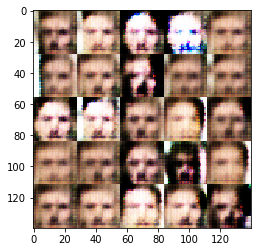

Epoch 1/1... Step: 1210... Discriminator Loss: 1.0400... Generator Loss: 1.4108
Epoch 1/1... Step: 1220... Discriminator Loss: 0.9581... Generator Loss: 0.7044
Epoch 1/1... Step: 1230... Discriminator Loss: 1.0620... Generator Loss: 1.0810
Epoch 1/1... Step: 1240... Discriminator Loss: 1.2503... Generator Loss: 1.2358
Epoch 1/1... Step: 1250... Discriminator Loss: 1.2339... Generator Loss: 0.6422
Epoch 1/1... Step: 1260... Discriminator Loss: 1.0339... Generator Loss: 0.9588
Epoch 1/1... Step: 1270... Discriminator Loss: 1.3007... Generator Loss: 0.7118
Epoch 1/1... Step: 1280... Discriminator Loss: 1.5613... Generator Loss: 0.4848
Epoch 1/1... Step: 1290... Discriminator Loss: 1.4316... Generator Loss: 0.9858
Epoch 1/1... Step: 1300... Discriminator Loss: 0.7902... Generator Loss: 1.1263


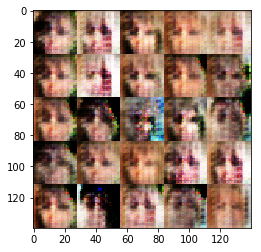

Epoch 1/1... Step: 1310... Discriminator Loss: 1.5392... Generator Loss: 0.4609
Epoch 1/1... Step: 1320... Discriminator Loss: 1.3294... Generator Loss: 0.8697
Epoch 1/1... Step: 1330... Discriminator Loss: 0.7261... Generator Loss: 0.9892
Epoch 1/1... Step: 1340... Discriminator Loss: 1.2098... Generator Loss: 1.1674
Epoch 1/1... Step: 1350... Discriminator Loss: 1.5164... Generator Loss: 0.4117
Epoch 1/1... Step: 1360... Discriminator Loss: 1.6387... Generator Loss: 0.3675
Epoch 1/1... Step: 1370... Discriminator Loss: 1.1589... Generator Loss: 0.5904
Epoch 1/1... Step: 1380... Discriminator Loss: 1.1604... Generator Loss: 0.6139
Epoch 1/1... Step: 1390... Discriminator Loss: 1.3169... Generator Loss: 1.1229
Epoch 1/1... Step: 1400... Discriminator Loss: 1.1956... Generator Loss: 0.9414


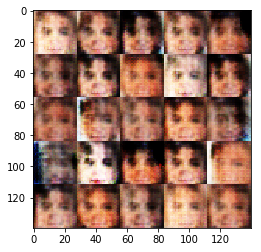

Epoch 1/1... Step: 1410... Discriminator Loss: 1.0001... Generator Loss: 0.7377
Epoch 1/1... Step: 1420... Discriminator Loss: 1.2626... Generator Loss: 0.8374
Epoch 1/1... Step: 1430... Discriminator Loss: 1.2585... Generator Loss: 0.6593
Epoch 1/1... Step: 1440... Discriminator Loss: 1.3177... Generator Loss: 0.9761
Epoch 1/1... Step: 1450... Discriminator Loss: 0.4892... Generator Loss: 1.3685
Epoch 1/1... Step: 1460... Discriminator Loss: 1.2041... Generator Loss: 0.8211
Epoch 1/1... Step: 1470... Discriminator Loss: 1.1268... Generator Loss: 1.0136
Epoch 1/1... Step: 1480... Discriminator Loss: 1.2487... Generator Loss: 0.9044
Epoch 1/1... Step: 1490... Discriminator Loss: 1.7083... Generator Loss: 0.7545
Epoch 1/1... Step: 1500... Discriminator Loss: 1.2104... Generator Loss: 0.8594


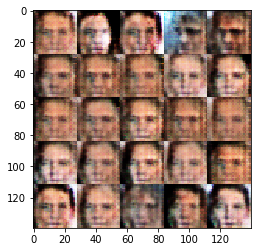

Epoch 1/1... Step: 1510... Discriminator Loss: 1.2120... Generator Loss: 0.5970
Epoch 1/1... Step: 1520... Discriminator Loss: 1.4236... Generator Loss: 1.1622
Epoch 1/1... Step: 1530... Discriminator Loss: 1.3847... Generator Loss: 0.8042
Epoch 1/1... Step: 1540... Discriminator Loss: 0.7079... Generator Loss: 0.8581
Epoch 1/1... Step: 1550... Discriminator Loss: 1.0405... Generator Loss: 0.8365
Epoch 1/1... Step: 1560... Discriminator Loss: 1.2856... Generator Loss: 1.3024
Epoch 1/1... Step: 1570... Discriminator Loss: 0.9672... Generator Loss: 1.2355
Epoch 1/1... Step: 1580... Discriminator Loss: 1.6088... Generator Loss: 1.0334
Epoch 1/1... Step: 1590... Discriminator Loss: 1.1036... Generator Loss: 0.8420
Epoch 1/1... Step: 1600... Discriminator Loss: 1.3948... Generator Loss: 0.9653


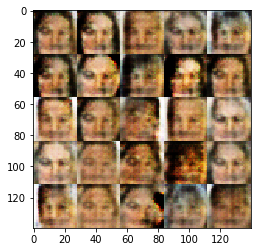

Epoch 1/1... Step: 1610... Discriminator Loss: 1.3935... Generator Loss: 0.8411
Epoch 1/1... Step: 1620... Discriminator Loss: 1.6822... Generator Loss: 0.7697
Epoch 1/1... Step: 1630... Discriminator Loss: 1.3841... Generator Loss: 0.4463
Epoch 1/1... Step: 1640... Discriminator Loss: 1.1673... Generator Loss: 1.2144
Epoch 1/1... Step: 1650... Discriminator Loss: 1.1772... Generator Loss: 0.7030
Epoch 1/1... Step: 1660... Discriminator Loss: 1.5519... Generator Loss: 0.4856
Epoch 1/1... Step: 1670... Discriminator Loss: 1.1337... Generator Loss: 1.6695
Epoch 1/1... Step: 1680... Discriminator Loss: 1.0675... Generator Loss: 0.8721
Epoch 1/1... Step: 1690... Discriminator Loss: 1.4037... Generator Loss: 0.7259
Epoch 1/1... Step: 1700... Discriminator Loss: 0.9080... Generator Loss: 0.7244


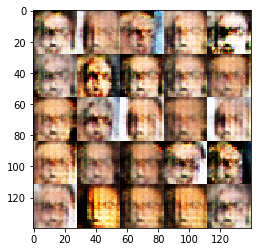

Epoch 1/1... Step: 1710... Discriminator Loss: 1.2047... Generator Loss: 0.9317
Epoch 1/1... Step: 1720... Discriminator Loss: 1.3228... Generator Loss: 0.9075
Epoch 1/1... Step: 1730... Discriminator Loss: 1.4938... Generator Loss: 1.0251
Epoch 1/1... Step: 1740... Discriminator Loss: 1.4085... Generator Loss: 0.8975
Epoch 1/1... Step: 1750... Discriminator Loss: 1.3161... Generator Loss: 0.5545
Epoch 1/1... Step: 1760... Discriminator Loss: 1.1835... Generator Loss: 0.6225
Epoch 1/1... Step: 1770... Discriminator Loss: 1.0197... Generator Loss: 0.8946
Epoch 1/1... Step: 1780... Discriminator Loss: 0.9595... Generator Loss: 0.9865
Epoch 1/1... Step: 1790... Discriminator Loss: 1.2689... Generator Loss: 0.8395
Epoch 1/1... Step: 1800... Discriminator Loss: 1.3540... Generator Loss: 0.7394


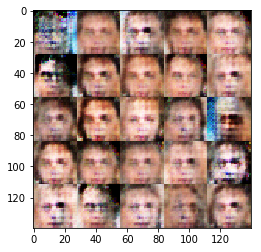

Epoch 1/1... Step: 1810... Discriminator Loss: 1.3267... Generator Loss: 0.7883
Epoch 1/1... Step: 1820... Discriminator Loss: 1.5120... Generator Loss: 0.4335
Epoch 1/1... Step: 1830... Discriminator Loss: 1.5336... Generator Loss: 0.7959
Epoch 1/1... Step: 1840... Discriminator Loss: 1.2020... Generator Loss: 0.7874
Epoch 1/1... Step: 1850... Discriminator Loss: 1.2215... Generator Loss: 0.7740
Epoch 1/1... Step: 1860... Discriminator Loss: 1.3367... Generator Loss: 0.7775
Epoch 1/1... Step: 1870... Discriminator Loss: 1.4279... Generator Loss: 0.7835
Epoch 1/1... Step: 1880... Discriminator Loss: 1.2197... Generator Loss: 0.7389
Epoch 1/1... Step: 1890... Discriminator Loss: 0.9756... Generator Loss: 1.5693
Epoch 1/1... Step: 1900... Discriminator Loss: 1.0694... Generator Loss: 0.7727


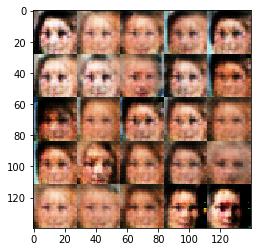

Epoch 1/1... Step: 1910... Discriminator Loss: 1.1472... Generator Loss: 1.0376
Epoch 1/1... Step: 1920... Discriminator Loss: 1.3027... Generator Loss: 0.7505
Epoch 1/1... Step: 1930... Discriminator Loss: 1.1473... Generator Loss: 0.6754
Epoch 1/1... Step: 1940... Discriminator Loss: 1.5654... Generator Loss: 0.4979
Epoch 1/1... Step: 1950... Discriminator Loss: 1.8973... Generator Loss: 0.3121
Epoch 1/1... Step: 1960... Discriminator Loss: 1.2719... Generator Loss: 0.7314
Epoch 1/1... Step: 1970... Discriminator Loss: 1.1274... Generator Loss: 0.8887
Epoch 1/1... Step: 1980... Discriminator Loss: 1.3152... Generator Loss: 0.6841
Epoch 1/1... Step: 1990... Discriminator Loss: 1.1469... Generator Loss: 0.8664
Epoch 1/1... Step: 2000... Discriminator Loss: 1.3018... Generator Loss: 0.8359


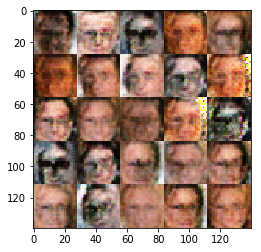

Epoch 1/1... Step: 2010... Discriminator Loss: 1.3365... Generator Loss: 0.7657
Epoch 1/1... Step: 2020... Discriminator Loss: 1.3937... Generator Loss: 0.5335
Epoch 1/1... Step: 2030... Discriminator Loss: 1.5716... Generator Loss: 0.8458
Epoch 1/1... Step: 2040... Discriminator Loss: 1.5110... Generator Loss: 0.5193
Epoch 1/1... Step: 2050... Discriminator Loss: 1.1106... Generator Loss: 0.7111
Epoch 1/1... Step: 2060... Discriminator Loss: 1.4075... Generator Loss: 0.9303
Epoch 1/1... Step: 2070... Discriminator Loss: 1.6173... Generator Loss: 0.4343
Epoch 1/1... Step: 2080... Discriminator Loss: 1.2018... Generator Loss: 0.6616
Epoch 1/1... Step: 2090... Discriminator Loss: 1.2702... Generator Loss: 0.7216
Epoch 1/1... Step: 2100... Discriminator Loss: 1.3061... Generator Loss: 0.8749


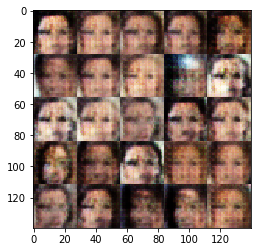

Epoch 1/1... Step: 2110... Discriminator Loss: 1.2378... Generator Loss: 0.5532
Epoch 1/1... Step: 2120... Discriminator Loss: 0.4967... Generator Loss: 1.5722
Epoch 1/1... Step: 2130... Discriminator Loss: 0.7523... Generator Loss: 0.9449
Epoch 1/1... Step: 2140... Discriminator Loss: 0.6428... Generator Loss: 1.5680
Epoch 1/1... Step: 2150... Discriminator Loss: 1.1713... Generator Loss: 0.7422
Epoch 1/1... Step: 2160... Discriminator Loss: 0.3243... Generator Loss: 2.0387
Epoch 1/1... Step: 2170... Discriminator Loss: 0.3934... Generator Loss: 1.3110
Epoch 1/1... Step: 2180... Discriminator Loss: 1.0430... Generator Loss: 1.2630
Epoch 1/1... Step: 2190... Discriminator Loss: 1.2596... Generator Loss: 1.2269
Epoch 1/1... Step: 2200... Discriminator Loss: 1.8289... Generator Loss: 0.2822


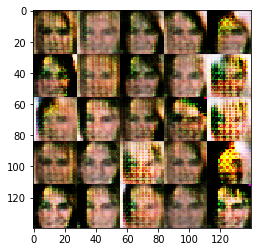

Epoch 1/1... Step: 2210... Discriminator Loss: 0.8014... Generator Loss: 1.3684
Epoch 1/1... Step: 2220... Discriminator Loss: 0.4559... Generator Loss: 1.0692
Epoch 1/1... Step: 2230... Discriminator Loss: 1.4858... Generator Loss: 0.8415
Epoch 1/1... Step: 2240... Discriminator Loss: 1.4202... Generator Loss: 1.9624
Epoch 1/1... Step: 2250... Discriminator Loss: 1.9161... Generator Loss: 0.2188
Epoch 1/1... Step: 2260... Discriminator Loss: 1.4891... Generator Loss: 1.1493
Epoch 1/1... Step: 2270... Discriminator Loss: 1.3198... Generator Loss: 0.9610
Epoch 1/1... Step: 2280... Discriminator Loss: 1.0882... Generator Loss: 0.9681
Epoch 1/1... Step: 2290... Discriminator Loss: 0.9100... Generator Loss: 1.1813
Epoch 1/1... Step: 2300... Discriminator Loss: 1.5541... Generator Loss: 0.3816


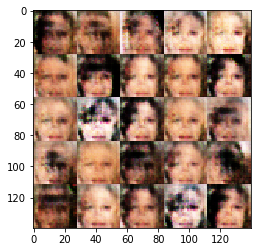

Epoch 1/1... Step: 2310... Discriminator Loss: 0.9702... Generator Loss: 0.9543
Epoch 1/1... Step: 2320... Discriminator Loss: 2.2153... Generator Loss: 0.2434
Epoch 1/1... Step: 2330... Discriminator Loss: 0.9367... Generator Loss: 0.8914
Epoch 1/1... Step: 2340... Discriminator Loss: 0.8709... Generator Loss: 0.8891
Epoch 1/1... Step: 2350... Discriminator Loss: 0.8809... Generator Loss: 1.2029
Epoch 1/1... Step: 2360... Discriminator Loss: 1.8084... Generator Loss: 0.2467
Epoch 1/1... Step: 2370... Discriminator Loss: 1.0635... Generator Loss: 0.8115
Epoch 1/1... Step: 2380... Discriminator Loss: 1.1386... Generator Loss: 0.9763
Epoch 1/1... Step: 2390... Discriminator Loss: 1.1719... Generator Loss: 2.0897
Epoch 1/1... Step: 2400... Discriminator Loss: 1.5124... Generator Loss: 0.5573


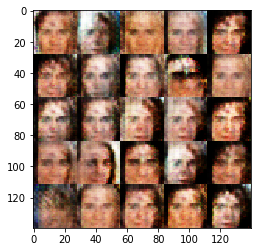

Epoch 1/1... Step: 2410... Discriminator Loss: 1.1499... Generator Loss: 0.9000
Epoch 1/1... Step: 2420... Discriminator Loss: 1.4711... Generator Loss: 0.4349
Epoch 1/1... Step: 2430... Discriminator Loss: 1.3193... Generator Loss: 0.7813
Epoch 1/1... Step: 2440... Discriminator Loss: 1.2727... Generator Loss: 0.8889
Epoch 1/1... Step: 2450... Discriminator Loss: 1.0110... Generator Loss: 0.6799
Epoch 1/1... Step: 2460... Discriminator Loss: 0.5694... Generator Loss: 0.9262
Epoch 1/1... Step: 2470... Discriminator Loss: 0.5937... Generator Loss: 0.8760
Epoch 1/1... Step: 2480... Discriminator Loss: 0.5095... Generator Loss: 1.2053
Epoch 1/1... Step: 2490... Discriminator Loss: 1.5927... Generator Loss: 1.7051
Epoch 1/1... Step: 2500... Discriminator Loss: 0.9143... Generator Loss: 1.0142


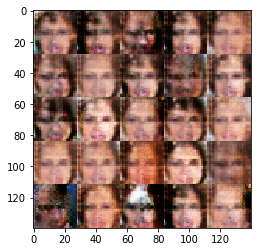

Epoch 1/1... Step: 2510... Discriminator Loss: 1.8409... Generator Loss: 0.3447
Epoch 1/1... Step: 2520... Discriminator Loss: 1.2584... Generator Loss: 0.6573
Epoch 1/1... Step: 2530... Discriminator Loss: 1.2181... Generator Loss: 0.9230
Epoch 1/1... Step: 2540... Discriminator Loss: 1.1033... Generator Loss: 0.8407
Epoch 1/1... Step: 2550... Discriminator Loss: 1.3711... Generator Loss: 0.8524
Epoch 1/1... Step: 2560... Discriminator Loss: 2.2883... Generator Loss: 2.5913
Epoch 1/1... Step: 2570... Discriminator Loss: 1.0710... Generator Loss: 1.1866
Epoch 1/1... Step: 2580... Discriminator Loss: 0.8024... Generator Loss: 1.1426
Epoch 1/1... Step: 2590... Discriminator Loss: 0.8146... Generator Loss: 0.9173
Epoch 1/1... Step: 2600... Discriminator Loss: 1.8096... Generator Loss: 0.5708


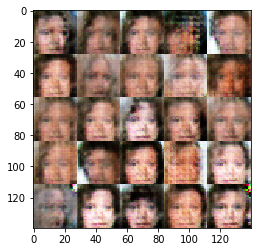

Epoch 1/1... Step: 2610... Discriminator Loss: 1.6703... Generator Loss: 0.3397
Epoch 1/1... Step: 2620... Discriminator Loss: 0.8008... Generator Loss: 1.0332
Epoch 1/1... Step: 2630... Discriminator Loss: 1.0415... Generator Loss: 0.8665
Epoch 1/1... Step: 2640... Discriminator Loss: 1.6573... Generator Loss: 0.3752
Epoch 1/1... Step: 2650... Discriminator Loss: 1.2677... Generator Loss: 1.1053
Epoch 1/1... Step: 2660... Discriminator Loss: 1.3218... Generator Loss: 0.6644
Epoch 1/1... Step: 2670... Discriminator Loss: 1.4132... Generator Loss: 0.7272
Epoch 1/1... Step: 2680... Discriminator Loss: 1.3971... Generator Loss: 0.7752
Epoch 1/1... Step: 2690... Discriminator Loss: 1.1026... Generator Loss: 1.3125
Epoch 1/1... Step: 2700... Discriminator Loss: 1.8132... Generator Loss: 0.6075


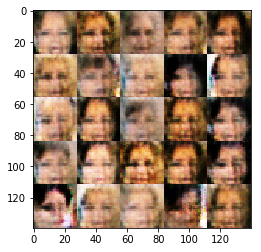

Epoch 1/1... Step: 2710... Discriminator Loss: 1.1248... Generator Loss: 0.8372
Epoch 1/1... Step: 2720... Discriminator Loss: 1.4352... Generator Loss: 0.4769
Epoch 1/1... Step: 2730... Discriminator Loss: 0.9863... Generator Loss: 0.7923
Epoch 1/1... Step: 2740... Discriminator Loss: 1.1053... Generator Loss: 0.9120
Epoch 1/1... Step: 2750... Discriminator Loss: 1.1660... Generator Loss: 0.8092
Epoch 1/1... Step: 2760... Discriminator Loss: 1.5542... Generator Loss: 0.4879
Epoch 1/1... Step: 2770... Discriminator Loss: 1.0206... Generator Loss: 0.6611
Epoch 1/1... Step: 2780... Discriminator Loss: 1.1726... Generator Loss: 0.6968
Epoch 1/1... Step: 2790... Discriminator Loss: 1.1408... Generator Loss: 0.6587
Epoch 1/1... Step: 2800... Discriminator Loss: 1.1475... Generator Loss: 0.8514


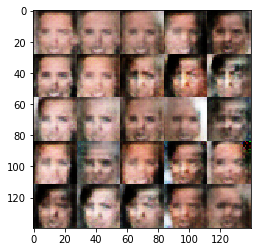

Epoch 1/1... Step: 2810... Discriminator Loss: 1.2268... Generator Loss: 0.6746
Epoch 1/1... Step: 2820... Discriminator Loss: 1.4168... Generator Loss: 0.7717
Epoch 1/1... Step: 2830... Discriminator Loss: 1.3192... Generator Loss: 0.7296
Epoch 1/1... Step: 2840... Discriminator Loss: 1.7967... Generator Loss: 0.4050
Epoch 1/1... Step: 2850... Discriminator Loss: 1.4444... Generator Loss: 1.0371
Epoch 1/1... Step: 2860... Discriminator Loss: 1.2905... Generator Loss: 1.3023
Epoch 1/1... Step: 2870... Discriminator Loss: 1.0646... Generator Loss: 0.5516
Epoch 1/1... Step: 2880... Discriminator Loss: 1.4056... Generator Loss: 1.0920
Epoch 1/1... Step: 2890... Discriminator Loss: 1.3752... Generator Loss: 1.3680
Epoch 1/1... Step: 2900... Discriminator Loss: 0.9071... Generator Loss: 1.0038


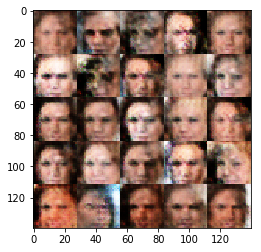

Epoch 1/1... Step: 2910... Discriminator Loss: 1.3992... Generator Loss: 0.8461
Epoch 1/1... Step: 2920... Discriminator Loss: 1.1533... Generator Loss: 0.5958
Epoch 1/1... Step: 2930... Discriminator Loss: 1.1128... Generator Loss: 0.8338
Epoch 1/1... Step: 2940... Discriminator Loss: 1.6238... Generator Loss: 0.6200
Epoch 1/1... Step: 2950... Discriminator Loss: 1.1055... Generator Loss: 0.8177
Epoch 1/1... Step: 2960... Discriminator Loss: 1.2422... Generator Loss: 0.7076
Epoch 1/1... Step: 2970... Discriminator Loss: 1.2432... Generator Loss: 0.5347
Epoch 1/1... Step: 2980... Discriminator Loss: 1.0809... Generator Loss: 0.9794
Epoch 1/1... Step: 2990... Discriminator Loss: 1.2884... Generator Loss: 0.6579
Epoch 1/1... Step: 3000... Discriminator Loss: 1.3665... Generator Loss: 0.5886


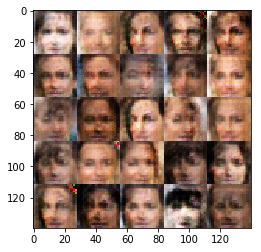

Epoch 1/1... Step: 3010... Discriminator Loss: 0.9861... Generator Loss: 0.8420
Epoch 1/1... Step: 3020... Discriminator Loss: 1.3286... Generator Loss: 0.7919
Epoch 1/1... Step: 3030... Discriminator Loss: 0.7583... Generator Loss: 0.7419
Epoch 1/1... Step: 3040... Discriminator Loss: 1.3488... Generator Loss: 0.8831
Epoch 1/1... Step: 3050... Discriminator Loss: 1.7213... Generator Loss: 0.3695
Epoch 1/1... Step: 3060... Discriminator Loss: 1.3086... Generator Loss: 0.7357
Epoch 1/1... Step: 3070... Discriminator Loss: 0.7342... Generator Loss: 0.7525
Epoch 1/1... Step: 3080... Discriminator Loss: 0.9309... Generator Loss: 0.8753
Epoch 1/1... Step: 3090... Discriminator Loss: 1.1626... Generator Loss: 0.9677
Epoch 1/1... Step: 3100... Discriminator Loss: 1.7605... Generator Loss: 0.4697


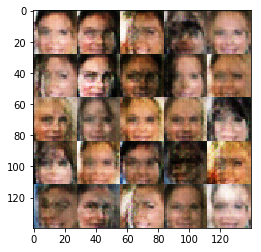

Epoch 1/1... Step: 3110... Discriminator Loss: 1.3431... Generator Loss: 0.7985
Epoch 1/1... Step: 3120... Discriminator Loss: 1.2797... Generator Loss: 0.7343
Epoch 1/1... Step: 3130... Discriminator Loss: 1.4482... Generator Loss: 1.0558
Epoch 1/1... Step: 3140... Discriminator Loss: 0.8535... Generator Loss: 0.9090
Epoch 1/1... Step: 3150... Discriminator Loss: 1.1761... Generator Loss: 0.5779
Epoch 1/1... Step: 3160... Discriminator Loss: 1.5285... Generator Loss: 0.5704


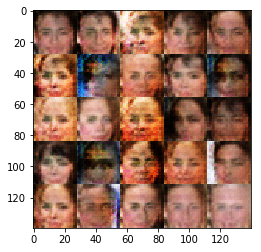

Final discriminator loss: 1.5285, final generator loss: 0.5704
Done at 2018-03-18 10:13:20 - elapsed time: 0:16:53.737236


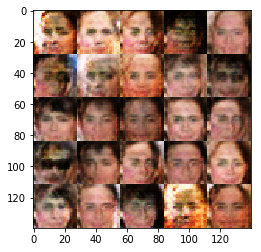

In [20]:
batch_size = 64
z_dim = 100
learning_rate =  0.002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.